## DEFUNCT CODE

This is scratch code to implement the oxygen calculation.

The function has now been moved into calc_oxy.py (March 2022)

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%reload_ext autoreload
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import datetime
from setdir import *
from plotglider import *
from scipy.io import loadmat # to load bathymetry
import xarray as xr
#import seaborn as sns
import glob
from scipy import stats
import cmocean
import gsw

In [3]:
# Load latest full dataset and gridded profiles
glider_names = {
    'unit_409': 'Grease',
    'unit_398': 'Churchill',
}
unit_list = [(k) for k in glider_names.keys()]

for uname in unit_list:
    # Glider data
    fname = uname+'_data*nc'

    # Extract a list with the names of existing raw data files
    existing_files = glob.glob(cat_proc_path(fname))

    # Check whether there are any
    if len(existing_files) > 0:
        # Extract the end date from the filename
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]

        # Open the dataset
        data_ds = xr.open_dataset(latest_file)
        
        if uname=='unit_409':
            exec('unit409=data_ds.copy()')
        elif uname=='unit_398':
            exec('unit398=data_ds.copy()')
        
    #Glider positions
    fname = uname+'_position_2022*nc'

    # Extract a list with the names of existing raw data files
    existing_files = glob.glob(cat_raw_path(fname))

    if len(existing_files) >0:
        existing_files = sorted(existing_files)
        latest_file = existing_files[-1]
        
        pos_ds = xr.open_dataset(latest_file)
        
        if uname=='unit_409':
            exec('unit409pos=pos_ds.copy()')
        elif uname=='unit_398':
            exec('unit398pos=pos_ds.copy()')
            
    # Gridded glider data
    fname = uname+'_bin10m.nc'
    grid_ds = xr.open_dataset(cat_proc_path(fname))
    
    if uname=='unit_409':
        exec('grid409=grid_ds.copy()')
    elif uname=='unit_398':
        exec('grid398=grid_ds.copy()')
        
            
# Location for bathymetry file
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
input_bathy_file = cat_proc_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]




In [46]:
#function [o2_mmolL,o2_mmolkg,o2_mlL,o2_solmmolkg] = #geto2(o2phase,T,PSS,P,lon,lat,varargin)
# O2 concentration function according to procedure detailed under:
# http://www.aanderaa.com/productsdetail.php?Oxygen-Optodes-2
#
# Procedure for calculating the oxygen concentration externally according
# to procedure in spreadsheet (TD-280-Oxygen-Optode-Calculation.xls) given
# the foil 7 part foil coefficient(SVUFoilCoef). Calculations are based on
# the modified Stern-Volmer formula proposed by Uchida et al. (2008, J.
# Atm. Oceanic Tech.)
#
# Hardcoded foil ceofficients for VITALS2016, TRINITY2018 Missions
# Foils are SN-124, SN-333
#
# Returns [mmol/L, mmol/kg, ml/L and solubility mmol/kg] 
#
# Translated from geto2.m, originally by
# Nicolai Bronikowski
# Memorial University of Newfoundland
# nbronikowski@mun.ca

from seawater import eos80 as sw

def geto2(o2phase,T,PSS,P,lon,lat,varargin):
    SVUFoilCoef = []; # Oxygen Optode Stern Volmer Coefficients
    Mission = []; # Mission
    SN = [];  # Oxygen Sensor Serial Number
    sal_set = 0;

    # Serial number 232
    SVUFoilCoef = [ 2.72495E-03, 
                    1.14452E-04, 
                    2.32433E-06, 
                    2.17482E+02,  
                   -2.94188E-01, 
                   -5.43610E+01,
                    4.27084E+00]
    
    ##Calculation routine:
    PT0 = sw.ptmp(PSS,T,P,0)
    C1 = SVUFoilCoef
    Pr = o2phase
    
    ##Response time correction (Bittig)
    
    ## Apply Stern Volmer Eq. Uchida (2008) to calculate molar oxy
    Ksv = C1[0]+T*C1[1]+np.square(T)*C1[2]
    Po = T*C1[4]+C1[3]
    Pc = (Pr*C1[6])+C1[5]
    
    o2 = np.divide(np.divide(Po,Pc)-1,Ksv)
    
    ## Next compute pres. and salt compensation (Uchida)
    B0 = -6.24097e-3
    B1 = -6.93498e-3
    B2 = -6.90358e-3
    B3 = -4.29155e-3
    C0 = -3.11680e-7
    
    coeff_p = 0.032 # Updated Uchida 2008, Aanderaa used to be 0.04
    
    Ts = np.log(np.divide(298.15 - T,273.15+T))
    
    comp_factor = np.exp((PSS-sal_set)*(B0+(Ts*B1)+(np.square(Ts)*B2)+
                                       ((Ts*Ts*Ts)*B3)) +
                       (np.square(PSS)-np.square(sal_set))*C0)
    
    press_comp = ((abs(P)/1000)*coeff_p)+1
    
    ## 5) Compute molar, molal and ml/L oxy conc
    dens = sw.dens(PSS,T,P)
    o2_mmolL = o2*comp_factor*press_comp
    o2_mmolkg = (o2_mmolL/(dens/1000))
    o2_mlL = (dens-1000-T + 1000)*o2_mmolkg/44660
    o2_solmmolkg = gsw.O2sol_SP_pt(PSS,PT0)
                       
    

    return o2_mmolL

In [34]:
SVUFoilCoef = [ 2.72495E-03, 
                1.14452E-04, 
                2.32433E-06, 
                2.17482E+02,  
               -2.94188E-01, 
               -5.43610E+01,
                4.27084E+00]

C1 = SVUFoilCoef
C1[1]

0.000114452

In [35]:
temp = unit409.sci_water_temp
salinity = unit409.derived_salinity
pres = unit409.pressure_dbar
o2calp = unit409.sci_oxy4_calphase
o2conc = unit409.sci_oxy4_oxygen
Sset = 0
OxyLim = [290, 315]
id = ~np.isnan(o2conc)

N = len(unit409.time)
longi = np.nanmean(unit409.m_gps_lon)*np.ones(N)
lati = np.nanmean(unit409.m_gps_lat)*np.ones(N)


In [47]:
temp = unit409.sci_water_temp
salinity = unit409.derived_salinity
pres = unit409.pressure_dbar
o2calp = unit409.sci_oxy4_calphase
o2conc = unit409.sci_oxy4_oxygen
Sset = 0
OxyLim = [290, 315]
id = ~np.isnan(o2conc)



o2conc_cal = geto2(o2calp,temp,salinity,pres,
                   longi,lati,{'Deployment','TERIFIC2',
                   'Optode','num','SetSalinity',Sset})


o2conc_cal

<xarray.DataArray (time: 86112)>
array([321.34133503, 323.30946946, 324.97112229, ...,          nan,
                nan, 300.81909241])
Coordinates:
  * time     (time) datetime64[ns] 2021-12-12 ... 2022-02-16T11:07:00

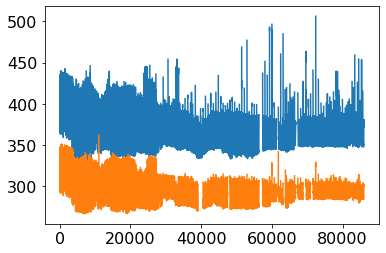

In [49]:
plt.plot(o2conc)
plt.plot(o2conc_cal)

In [ ]:
salinity_abs = gsw_SA_from_SP(salinity,pres,longi,lati);
theta_0 = gsw_pt0_from_t(salinity_abs,temp,pres);
ctemp   = gsw_CT_from_pt(salinity_abs,theta_0);
sigma_0 = gsw_sigma0(salinity_abs,ctemp);
rho     = gsw_rho(salinity_abs,ctemp,pres);

In [25]:
# Initialise the figure directory
figdir = create_figdir()

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

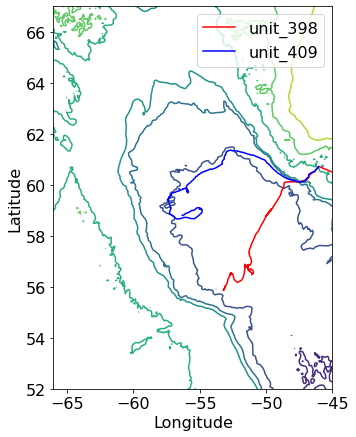

In [39]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks_pos(bathylon,bathylat,bathy,unit409pos,unit398pos)

# Simple color sections

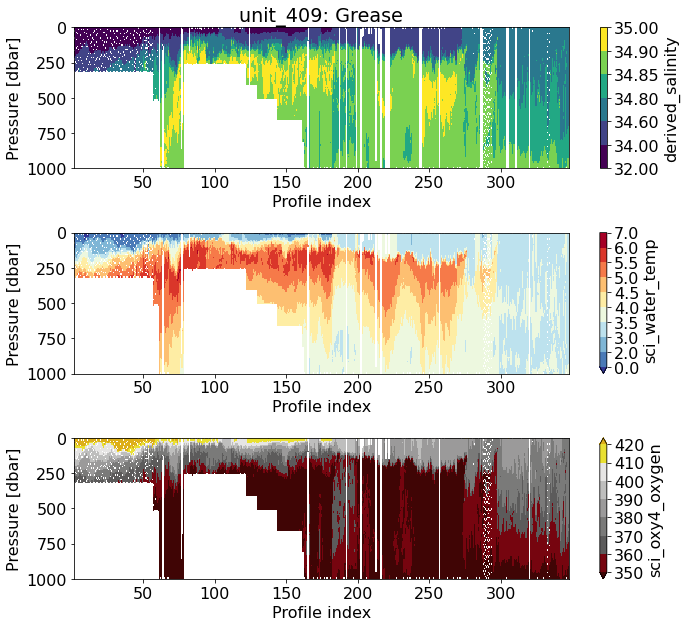

In [41]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_flbbcd_chlor_units', 'sci_flbbcd_cdom_units', 
           'sci_flbbcd_bb_units'
          ]
varlist2 = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
            ]
    
#plot_sxn(grid409, varlist)
plot_sxn(grid409, varlist2)
## ISSUE: Need to add a time axes below the divenumber axis.
## ISSUE: Need better plotting of the gappy wetlabs data

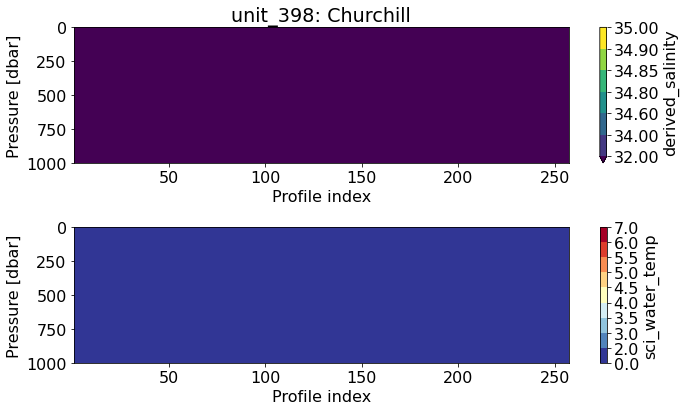

In [42]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen',
           'sci_bb2flsv9_chl_scaled', 'sci_bb2flsv9_b532_scaled', 
           'sci_bb2flsv9_b700_scaled'
          ]
varlist3 = ['derived_salinity', 'sci_water_temp'
          ]
plot_sxn(grid398, varlist3)